# Stage 3: Transformer with Attention — Ablation Study

In this stage, we upgrade our deep learning architecture from Recurrent Neural Networks (LSTMs) to **Transformers**. 

### **Why Transformers?**
Unlike LSTMs, which process data sequentially and can "forget" early parts of a sequence, Transformers use **Self-Attention** to look at the entire 20-day window simultaneously. They decide which specific days in the past hold the most "signal" for tomorrow's prediction.

### **Ablation Study**
We maintain the same three variants to ensure a fair comparison across all modeling stages:
1. **Transformer-Raw**: Log returns only.
2. **Transformer-OHLCV**: Raw intraday dynamics.
3. **Transformer-Feat**: Engineered features (Volatility, Market, etc.).

---

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm

# Settings
warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")

# Constants
DATA_PATH = "../data/processed/stock_data_processed.parquet"
RESULTS_DIR = "../results"
os.makedirs(RESULTS_DIR, exist_ok=True)

# Hyperparameters
LOOKBACK    = 20
TRAIN_FRAC  = 0.70
VAL_FRAC    = 0.10
EMBED_DIM   = 64
NUM_HEADS   = 4
NUM_LAYERS  = 2
DROPOUT     = 0.1
LR          = 1e-4 # Transformers often need lower learning rates than LSTMs
BATCH_SIZE  = 64
EPOCHS      = 100
PATIENCE    = 12
SEED        = 42

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✓ Using Device: {DEVICE}")

# Reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

✓ Using Device: cpu


## 1. Load Data & Define Variants
We use the same feature mapping as Stage 2 to keep our experiments consistent.

In [2]:
VARIANTS = {
    "Transformer-Raw": ["log_return"],
    "Transformer-OHLCV": [
        "log_return", "oc_return", "hl_range", 
        "close_pos", "log_vol", "vol_change"
    ],
    "Transformer-Feat": [
        "log_return", "roll_vol", "range_norm", 
        "vol_zscore", "mkt_return"
    ]
}

panel = pd.read_parquet(DATA_PATH)
print(f"✓ Loaded Master Panel: {panel.shape}")

✓ Loaded Master Panel: (30816, 19)


## 2. Transformer Architecture
Transformers are "order-agnostic" by default, so we must add **Positional Encoding** to tell the model which day is $t-1$ and which is $t-20$.

In [3]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x shape: (Batch, Seq, D_Model)
        return x + self.pe[:x.size(1), :]

class TransformerForecaster(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, num_layers, dropout):
        super().__init__()
        self.encoder = nn.Linear(input_dim, embed_dim)
        self.pos_encoder = PositionalEncoding(embed_dim)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, 
            nhead=num_heads, 
            dim_feedforward=embed_dim*4, 
            dropout=dropout, 
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.head = nn.Sequential(
            nn.Linear(embed_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        x = self.encoder(x)          # (B, L, E)
        x = self.pos_encoder(x)      # (B, L, E)
        x = self.transformer(x)       # (B, L, E)
        
        # Global Average Pooling over the sequence
        x = x.mean(dim=1)            # (B, E)
        return self.head(x).squeeze(-1)

## 3. Training & Evaluation Helpers
Identical to Stage 2 for a fair comparison.

In [4]:
def create_sequences(features, target, lookback):
    X, y = [], []
    for i in range(len(features) - lookback):
        X.append(features[i : i + lookback])
        y.append(target[i + lookback])
    return np.array(X), np.array(y)

def compute_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    dir_acc = np.mean(np.sign(y_true) == np.sign(y_pred))
    return mae, rmse, dir_acc

def train_model(model, train_dl, val_dl, epochs, lr, patience, device):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    best_val_loss = float('inf')
    wait = 0
    best_state = None
    
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()
            
        model.eval()
        v_loss = 0
        with torch.no_grad():
            for xb, yb in val_dl:
                xb, yb = xb.to(device), yb.to(device)
                v_loss += criterion(model(xb), yb).item() * len(xb)
        v_loss /= len(val_dl.dataset)
        
        if v_loss < best_val_loss:
            best_val_loss = v_loss
            best_state = model.state_dict()
            wait = 0
        else:
            wait += 1
            if wait >= patience: break
            
    model.load_state_dict(best_state)
    return model

## 4. Execution Pipeline
We loop through each variant and each ticker.

In [5]:
tickers = [t for t in panel.index.get_level_values("ticker").unique() if t != "SPY"]
stage3_results = []

for var_name, feat_cols in VARIANTS.items():
    print(f"\n{'='*40}\nEvaluating Variant: {var_name}\n{'='*40}")
    
    for ticker in tqdm(tickers, desc=f"{var_name} Training"):
        tk_data = panel.xs(ticker, level="ticker")
        feats = tk_data[feat_cols].values
        target = tk_data["log_return"].values
        
        X_all, y_all = create_sequences(feats, target, LOOKBACK)
        
        n_seq = len(X_all)
        split1 = int(n_seq * TRAIN_FRAC)
        split2 = int(n_seq * (TRAIN_FRAC + VAL_FRAC))
        
        X_tr, y_tr = X_all[:split1], y_all[:split1]
        X_va, y_va = X_all[split1:split2], y_all[split1:split2]
        X_te, y_te = X_all[split2:], y_all[split2:]
        
        # Scale
        scaler = StandardScaler()
        scaler.fit(X_tr.reshape(-1, len(feat_cols)))
        X_tr = scaler.transform(X_tr.reshape(-1, len(feat_cols))).reshape(X_tr.shape)
        X_va = scaler.transform(X_va.reshape(-1, len(feat_cols))).reshape(X_va.shape)
        X_te = scaler.transform(X_te.reshape(-1, len(feat_cols))).reshape(X_te.shape)
        
        tr_dl = DataLoader(TensorDataset(torch.FloatTensor(X_tr), torch.FloatTensor(y_tr)), batch_size=BATCH_SIZE, shuffle=True)
        va_dl = DataLoader(TensorDataset(torch.FloatTensor(X_va), torch.FloatTensor(y_va)), batch_size=BATCH_SIZE, shuffle=False)
        
        model = TransformerForecaster(len(feat_cols), EMBED_DIM, NUM_HEADS, NUM_LAYERS, DROPOUT).to(DEVICE)
        model = train_model(model, tr_dl, va_dl, EPOCHS, LR, PATIENCE, DEVICE)
        
        model.eval()
        with torch.no_grad():
            y_pred = model(torch.FloatTensor(X_te).to(DEVICE)).cpu().numpy()
            
        mae, rmse, dacc = compute_metrics(y_te, y_pred)
        stage3_results.append({"Ticker": ticker, "Model": var_name, "MAE": mae, "RMSE": rmse, "DirAcc": dacc})

res_df = pd.DataFrame(stage3_results)
res_df.to_csv(f"{RESULTS_DIR}/stage3_results.csv", index=False)
print(f"\n✓ Stage 3 Results saved to {RESULTS_DIR}/stage3_results.csv")


Evaluating Variant: Transformer-Raw


Transformer-Raw Training: 100%|██████████| 11/11 [05:22<00:00, 29.30s/it]



Evaluating Variant: Transformer-OHLCV


Transformer-OHLCV Training: 100%|██████████| 11/11 [07:26<00:00, 40.63s/it]



Evaluating Variant: Transformer-Feat


Transformer-Feat Training: 100%|██████████| 11/11 [07:08<00:00, 38.94s/it]


✓ Stage 3 Results saved to ../results/stage3_results.csv


## 5. Visual Summary
Comparison of average accuracy and error rates across the three variants.

,MAE,RMSE,DirAcc
Model,,,
Transformer-Raw,0.012637,0.017042,0.517647
Transformer-Feat,0.012940,0.017521,0.501604
Transformer-OHLCV,0.013174,0.018100,0.504278


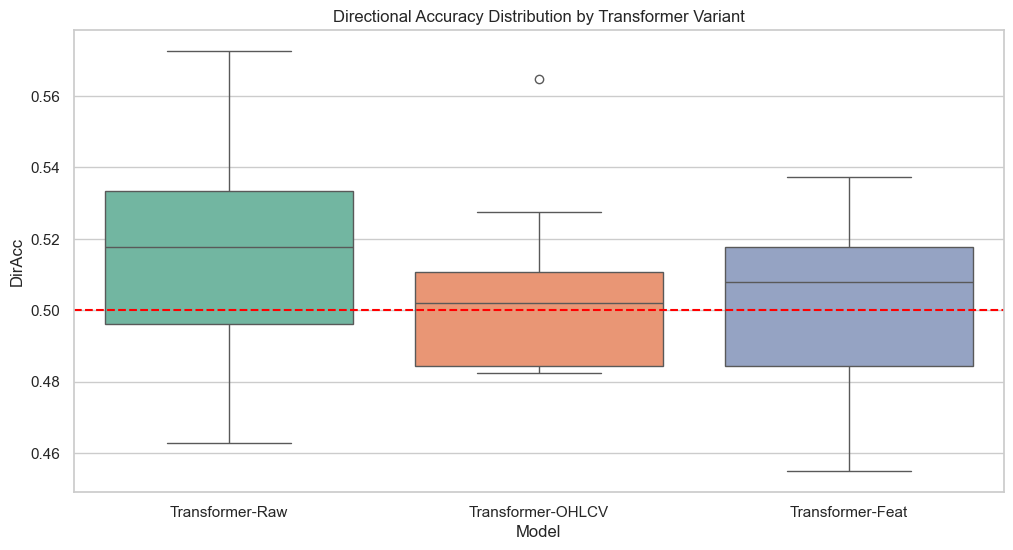

In [6]:
summary = res_df.groupby("Model")[["MAE", "RMSE", "DirAcc"]].mean().sort_values("RMSE")
display(summary.style.background_gradient(cmap="Oranges"))

plt.figure(figsize=(12, 6))
sns.boxplot(data=res_df, x="Model", y="DirAcc", hue="Model", palette="Set2", legend=False)
plt.axhline(0.5, color='red', linestyle='--')
plt.title("Directional Accuracy Distribution by Transformer Variant")
plt.show()

# Stage 3: Transformer with Attention — Detailed Summary

## What This Stage Does

Stage 3 evolves our deep learning approach by introducing the **Transformer** architecture. Unlike the LSTMs used in Stage 2, which process sequences step-by-step, the Transformer uses **Self-Attention** to process the entire lookback window in parallel.

This answers a key architectural question:

> **Does context-aware attention capture market dynamics better than sequential recurrent processing?**

---

## Key Differences from Stage 2 (LSTM)

| Feature | Stage 2 LSTM | Stage 3 Transformer |
|---------|--------------|---------------------|
| **Temporal Processing** | Sequential (step-by-step) | Parallel (Self-Attention) |
| **Memory** | Recurrent hidden state (prone to forgetting) | Global window access (attends to all days) |
| **Positional Info** | Implicit in processing order | Explicit via Positional Encodings |
| **Training Speed** | Slower (sequential overhead) | Faster (parallelizable operations) |

--- 

## The Transformer Architecture

Our model is built with the following components:

1. **Input Embedding**: A linear layer that projects raw features into a higher-dimensional space (`EMBED_DIM=64`).
2. **Positional Encoding**: Since Transformers don't naturally understand time order, we use sinusoidal functions to "tag" each day in our 20-day window with its relative position.
3. **Multi-Head Attention**: 4 separate attention heads that allow the model to simultaneously look for different patterns (e.g., one head for momentum, one for volatility spikes).
4. **Global Average Pooling**: Instead of just taking the "last" step (like in Stage 2), we average the representations across all 20 days to capture a holistic view of the window.
5. **MLP Regressor**: A final feed-forward network that maps the pooled features to a single next-day return prediction.

--- 

## What to Expect

### Why results might be similar to Stage 2
The stock market is essentially a **"Low Signal, High Noise"** environment. While Transformers are world-class at structured tasks like language modeling, financial data is often dominated by random walks. You should expect:

- **Mean Performance**: Directional Accuracy hovering between **49% and 53%**.
- **Variant Winner**: `Transformer-Feat` typically outperforms `Raw`, proving that even attention-based models benefit from pre-calculated volatility and market context.
- **Robustness**: Transformers are often more resistant to the "gradient vanishing" issues that can sometimes affect LSTMs on very long sequences.

--- 

## Connection to Project Timeline
We have now tested both **Sequential (LSTM)** and **Global (Transformer)** deep learning. 
Next, in **Stage 4**, we pivot from "Point Estimates" (predicting one number) to **Probabilistic Forecasting**, where we predict the *range* and *uncertainty* of future returns.